In [221]:
import cv2
import urllib
import numpy as np
import matplotlib.pyplot as plt

Pre Processing (InshaaAllah)

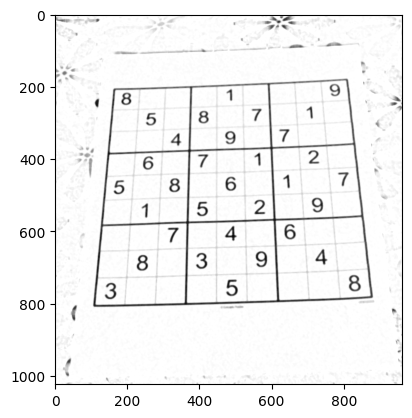

In [222]:
req = urllib.request.urlopen('https://live.staticflickr.com/8027/6978422072_33ac92fe1a_b.jpg')
arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
image = cv2.imdecode(arr, -1) #'Load it as it is'
'''filename = 'Test Cases\\10-Mal7wFelfel.jpg'
image = cv2.imread(filename)'''
img = cv2.GaussianBlur(image,(5,5),0)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 5)
mask = np.zeros((gray.shape),np.uint8)
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(11,11))

close = cv2.morphologyEx(gray,cv2.MORPH_CLOSE,kernel1)
div = np.float32(gray)/(close)
res = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))
plt.imshow(res, cmap="gray");

Thresholding and finidng all contours to isolate outer frame

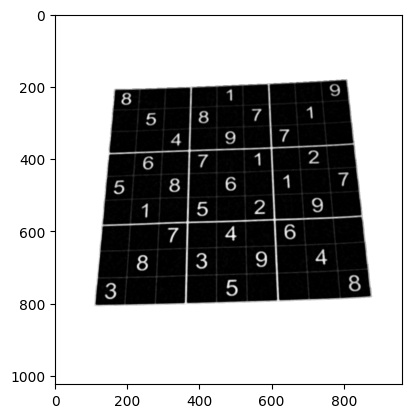

In [223]:
thresh = cv2.adaptiveThreshold(res,255,0,1,19,2)
contour,hier = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

max_area = 0
best_cnt = None
for cnt in contour:
    area = cv2.contourArea(cnt)
    if area > 1000:
        if area > max_area:
            max_area = area
            best_cnt = cnt

cv2.drawContours(mask,[best_cnt],0,255,-1)
cv2.drawContours(mask,[best_cnt],0,0,2)

res = cv2.bitwise_and(res,mask)
res1 = cv2.bitwise_not(res)
plt.imshow(res1, cmap="gray");

Sorting contours

In [224]:
contours, hierarchy = cv2.findContours(res.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)
polygon = contours[0]


Finding corners

In [225]:
import operator
bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in
                      polygon]), key=operator.itemgetter(1))
top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in
                  polygon]), key=operator.itemgetter(1))
bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in
                     polygon]), key=operator.itemgetter(1))
top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in
                   polygon]), key=operator.itemgetter(1))

In [226]:
[polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

[array([165, 207], dtype=int32),
 array([806, 180], dtype=int32),
 array([875, 783], dtype=int32),
 array([107, 806], dtype=int32)]

Outer frame plotting

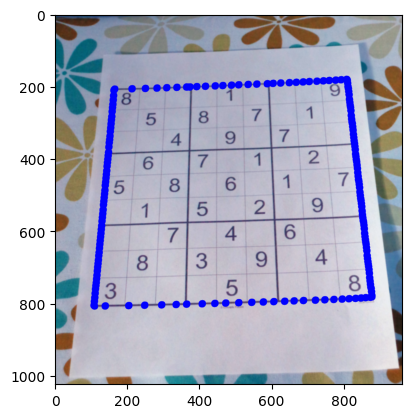

In [227]:
image_with_corners = img.copy()

# Draw circles or points at the corner locations
for corner in polygon:
    for corner in polygon:
       cv2.circle(image_with_corners, tuple(corner[0]), 10, (0, 0, 255), -1)  # Red color (BGR format), adjust the radius

# Display the image with corners
plt.imshow(image_with_corners)



In [228]:
def distance_between(p1, p2):
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))

In [229]:
top_left, top_right, bottom_right, bottom_left = polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0],polygon[bottom_left][0]
src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
side = max([  distance_between(bottom_right, top_right),
            distance_between(top_left, bottom_left),
            distance_between(bottom_right, bottom_left),
            distance_between(top_left, top_right) ])

Warping

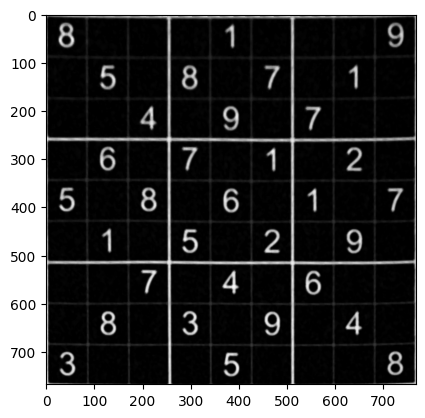

In [230]:
dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
m = cv2.getPerspectiveTransform(src, dst)
warp = cv2.warpPerspective(res1, m, (int(side), int(side)))
plt.imshow(warp,cmap = "gray")


Separating the tiles

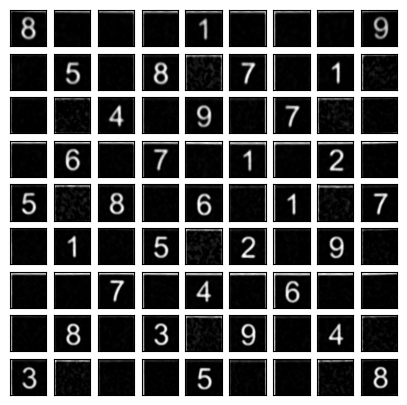

In [231]:
M = warp.shape[0] // 9
N = warp.shape[1] // 9
number_tiles = []
for i in range(9):
    number_tiles.append([])
    for j in range(9):
        tile = warp[i*M:(i+1)*M, j*N:(j+1)*N]
        number_tiles[i].append(tile)

_, axes = plt.subplots(9, 9, figsize=(5, 5))
for i, row in enumerate(axes):
    for j, col in enumerate(row):
        col.imshow(number_tiles[i][j], cmap="gray");
        col.get_xaxis().set_visible(False)
        col.get_yaxis().set_visible(False)